# А/В тесты. Задание 2

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-10-25 по 2024-10-31 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

- Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
- Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
- Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
- Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. При выполнении задания важно обосновать и аргументировать ваш вывод.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20241120',
'user':'student',
'password':'dpo_python_2020'
}

#текст запроса
query = '''
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
from {db}.feed_actions
WHERE toDate(time) >= '2024-10-25' and toDate(time) <= '2024-10-31'
    and exp_group IN (2, 1)
GROUP BY exp_group, user_id
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [3]:
# рассмотрим полученый df
df.head(15)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,13,44,0.295455
9,2,24239,40,90,0.444444


In [4]:
# проверим размерность групп
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

Размер групп выглядит нормальной и подходит для дальнейшего анализа

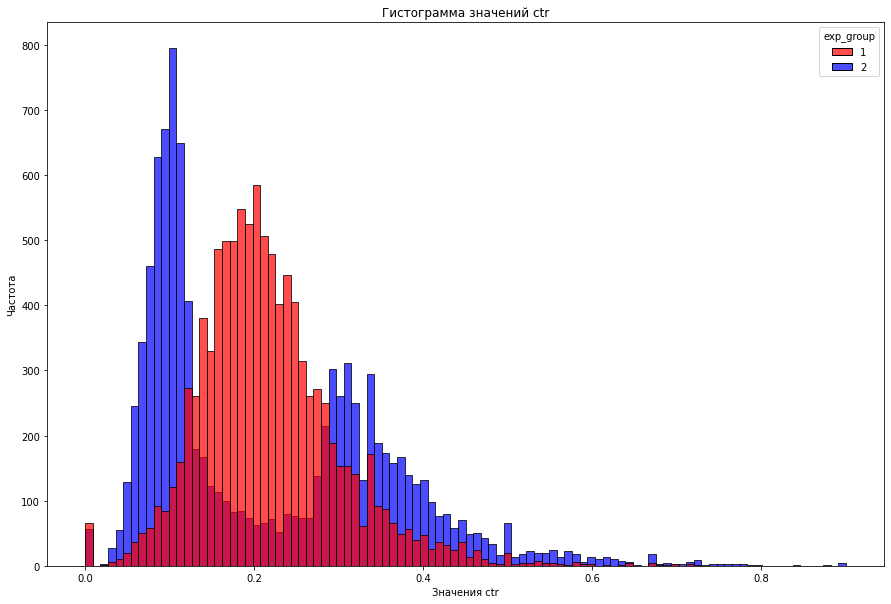

In [30]:
# построим гистограмму распределений ctr
plt.figure(figsize=(15, 10))
sns.histplot(data=df, x= 'ctr', hue='exp_group', palette = ['r', 'b'], bins=100, kde=False, alpha=0.7)
plt.title('Гистограмма значений ctr')
plt.xlabel('Значения ctr')
plt.ylabel('Частота')
plt.show()

## Проведем t-тест

- Нулевая гипотеза (H₀) в t-тесте: средние значения двух групп одинаковы.   
- Альтернативная гипотеза (H₁): средние значения двух групп различаются.

In [6]:
results = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
alpha = 0.05

print('Среднее первой выборки', np.mean(df[df.exp_group == 1].ctr).round(5))
print('Среднее второй выборки', np.mean(df[df.exp_group == 2].ctr).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.21677
Среднее второй выборки 0.2161
t-статистика = 0.4051491913112757
p-значение = 0.685373331140751
Не получилось отвергнуть нулевую гипотезу


Так как p-value = 0.685 значительно больше стандартного уровня значимости (например, α = 0.05), это означает, что нет достаточных доказательств, чтобы утверждать, что средние значения двух групп различаются.


In [7]:
print('Дисперсия первой выборки', np.var(df[df.exp_group == 1].ctr).round(5))
print('Дисперсия второй выборки', np.var(df[df.exp_group == 2].ctr).round(5))

Дисперсия первой выборки 0.00688
Дисперсия второй выборки 0.02041


**Вывод:** t-тест не выявил статистически значимых отличий между группами, однако визуальный анализ данных показывает явные различия. Это может свидетельствовать о том, что использование t-теста в данном случае не является корректным. Основные причины заключаются в том, что распределение данных демонстрирует значительные различия в дисперсиях между группами, а также не является одномодальным. Кроме того, для второй группы данные не соответствуют критериям нормальности, что делает результаты t-теста ненадежными. В таких ситуациях целесообразно рассмотреть альтернативные методы анализа, такие как непараметрические тесты (например, тест Манна-Уитни)

## Тест Манна-Уитни

- Нулевая гипотеза (H₀) в тесте Манна-Уитни утверждает, что распределения в двух группах идентичны 
- Альтернативная гипотеза (H₁) предполагает, что распределения в двух группах различаются

In [8]:
results = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                alternative = 'two-sided')
alpha = 0.05

print('Среднее первой выборки', np.mean(df[df.exp_group == 1].ctr).round(5))
print('Среднее второй выборки', np.mean(df[df.exp_group == 2].ctr).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.21677
Среднее второй выборки 0.2161
t-статистика = 55189913.0
p-значение = 4.632205841806026e-45
Отвергаем нулевую гипотезу


В данном случае p-value = 4.63e-45 намного меньше 0.05, что дает нам основание отвергнуть нулевую гипотезу и заключить, что между группами существует статистически значимое различие.

**Вывод:** Применение непараметрического теста Манна-Уитни является более оправданным. Этот тест не делает предположений о распределении данных, что делает его подходящим для анализа нашей метрики. Он устойчив к выбросам и асимметрии. Кроме того, тест Манна-Уитни особенно удобен в случаях, когда имеется большое количество уникальных значений, что характерно для нашего CTR.

## Сглаженный CTR

Проблема t-теста на пользовательском CTR в том, что у нас есть пользователи с небольшим количеством просмотров, а их CTR сильно зашумлен. Мы почти ничего не знаем о CTR пользователей, у которых всего 3 просмотра, независимо от количества их кликов. Когда у пользователя есть 20 просмотров, мы можем сделать приемлемую оценку CTR этого пользователя. А если у пользователя 200 просмотров, мы можем плюс/минус точно оценить его CTR.

In [9]:
# функция для расчета сглаженного ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [10]:
# расчитаем общий ctr для первой группы пользователей
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [11]:
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

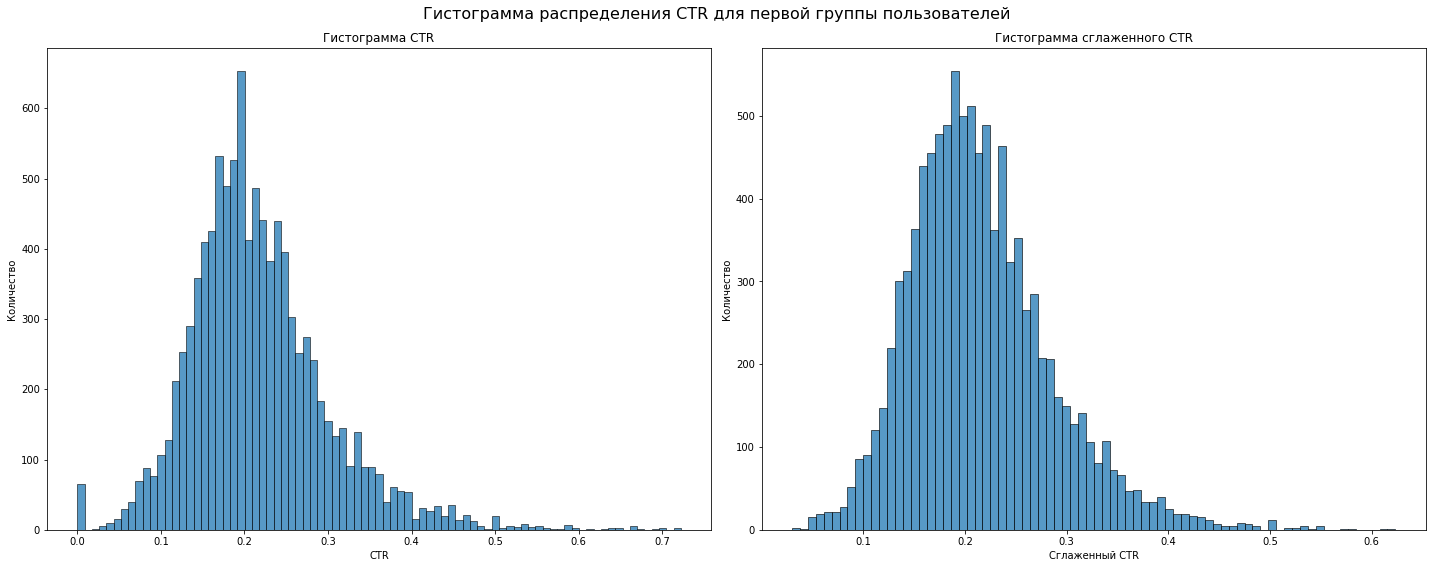

In [12]:
# построим два графика с обычным распределением и со сглаженным
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Гистограмма распределения CTR для первой группы пользователей', fontsize=16)

# построим первый график c обычным ctr
sns.histplot(group1.ctr, ax=axs[0], kde = False)
axs[0].set_title('Гистограмма CTR')
axs[0].set_title('Гистограмма CTR')
axs[0].set_xlabel('CTR')
axs[0].set_ylabel('Количество')

# построим график для сглаженного ctr
sns.histplot(group1.smothed_ctr,  ax=axs[1], kde = False)
axs[1].set_title('Гистограмма сглаженного CTR')
axs[1].set_xlabel('Сглаженный CTR')
axs[1].set_ylabel('Количество')

plt.tight_layout() 
plt.show()

Теперь сделаем тоже самое для пользователей второй группы

In [13]:
# расчитаем общий ctr для второй группы пользователей
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [14]:
group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [15]:
group2

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,9,108,0.083333,0.088921
6,2,23985,7,87,0.080460,0.087478
7,2,24523,11,101,0.108911,0.113661
8,2,32420,13,44,0.295455,0.286694
9,2,24239,40,90,0.444444,0.432084
...,...,...,...,...,...,...
19889,2,16512,13,79,0.164557,0.167238
19891,2,17146,0,10,0.000000,0.069868
19894,2,25383,42,127,0.330709,0.326121
19895,2,139020,17,41,0.414634,0.392348


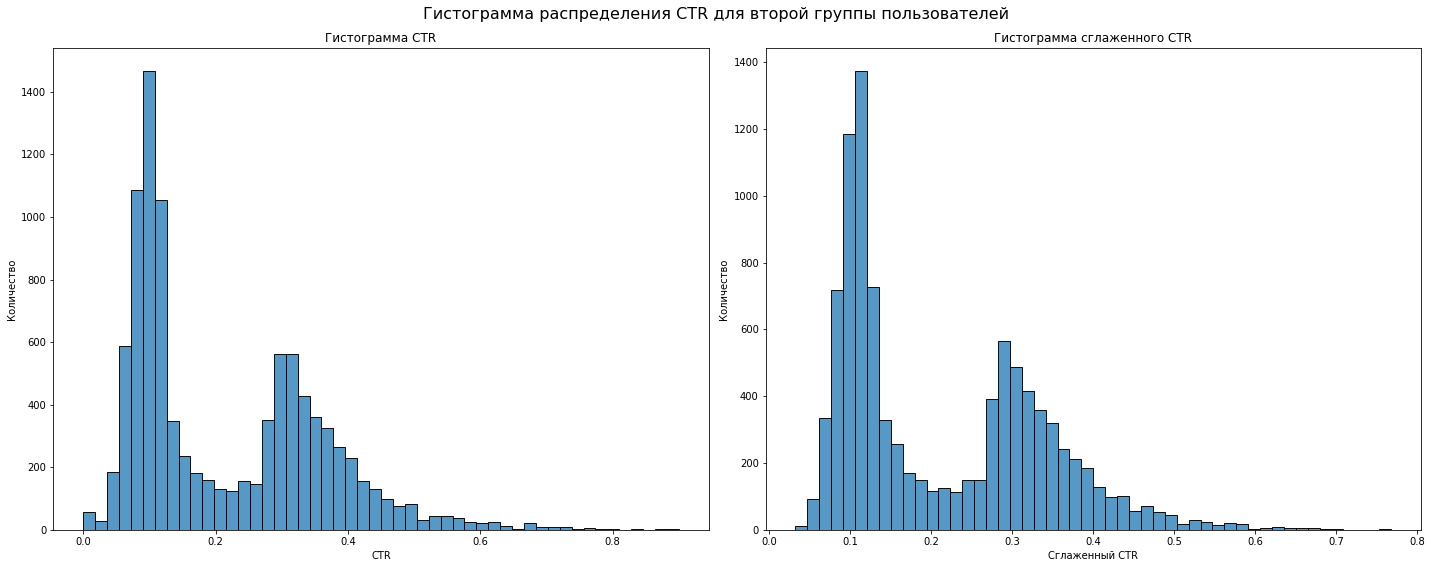

In [16]:
# построим два графика с обычным распределением и со сглаженным
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Гистограмма распределения CTR для второй группы пользователей', fontsize=16)

# построим первый график c обычным ctr
sns.histplot(group2.ctr, ax=axs[0], bins=50, kde = False)
axs[0].set_title('Гистограмма CTR')
axs[0].set_xlabel('CTR')
axs[0].set_ylabel('Количество')

# построим график для сглаженного ctr
sns.histplot(group2.smothed_ctr,  ax=axs[1], bins=50, kde = False)
axs[1].set_title('Гистограмма сглаженного CTR')
axs[1].set_xlabel('Сглаженный CTR')
axs[1].set_ylabel('Количество')


plt.tight_layout() 
plt.show()

**Вывод:** 
- После применения сглаживания распределение стало менее асимметричным, хвосты стали короче.
- Основная масса значений всё еще сосредоточена в диапазоне 0.0–0.2, однако распределение стало более равномерным.
- Сглаживание, уменьшило влияние пользователей с очень низкими или очень высокими CTR, что делает распределение более пригодным для анализа с помощью параметрических методов (например, t-теста).

## Проведем t-тест для сглаженных CTR

- Нулевая гипотеза (H₀) в t-тесте: средние значения двух групп одинаковы.   
- Альтернативная гипотеза (H₁): средние значения двух групп различаются.

In [18]:
results = stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)
alpha = 0.05

print('Среднее первой выборки', np.mean(group1.smothed_ctr).round(5))
print('Среднее второй выборки', np.mean(group2.smothed_ctr).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.21528
Среднее второй выборки 0.21351
t-статистика = 1.2447034376197381
p-значение = 0.2132595139150962
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Несмотря на то, что значение p-value стало меньше (было p-значение = 0.6853, стало 0.2132) по сравнению с проведением t-теста без сглаживания, этого все еще недостаточно для того, чтобы отвергнуть нулевую гипотезу о равенстве значений двух групп. 

## Пуассоновский бутстреп для подсчета разницы в CTR

In [19]:
# функция для подсчета глобального CTR для контрольной и тестируемой группы
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [20]:
# создадим списки из лайков и просмотров
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

# применим функцию для рассчета глобальных ctr
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

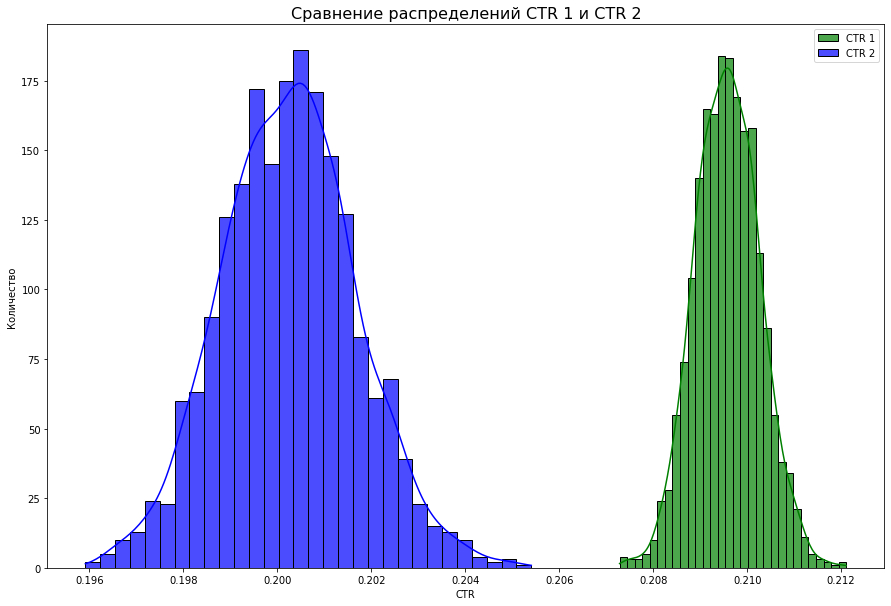

In [21]:
plt.figure(figsize=(15, 10))

sns.histplot(ctr1, color='green', label='CTR 1',kde=True, bins=30, alpha=0.7)
sns.histplot(ctr2, color='blue', label = 'CTR 2', kde=True,  bins=30, alpha=0.7)

plt.title('Сравнение распределений CTR 1 и CTR 2', fontsize=16)
plt.xlabel('CTR')
plt.ylabel('Количество')

plt.legend()
plt.show()

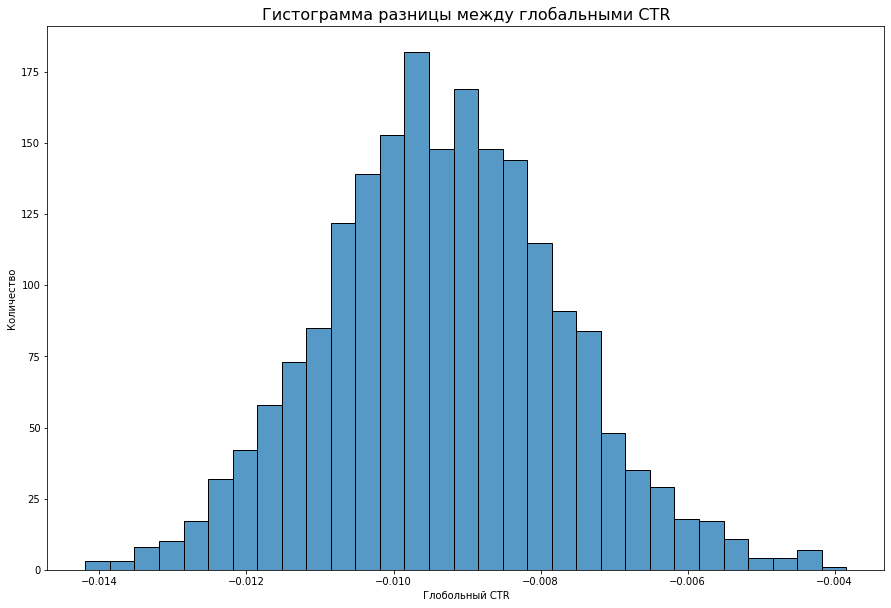

In [22]:
#Разница между глобальными CTR
plt.figure(figsize=(15, 10))

sns.histplot(ctr2 - ctr1)

plt.title('Гистограмма разницы между глобальными CTR', fontsize=16)
plt.xlabel('Глобольный CTR')
plt.ylabel('Количество')

plt.show()

**Вывод:** Гистограмма разности между группами не пересекает ноль, что указывает на значительное различие в показателях CTR между контрольной и тестируемой группами. Поскольку значения разности оказались отрицательными, это свидетельствует о том, что контрольная группа имеет более высокий CTR по сравнению с тестируемой группой. 

Таким образом, результаты анализа показывают, что группа 1 (контрольная) демонстрирует лучшие результаты по CTR, чем группа 2 (тестируемая). Это может указывать на то, что изменения или нововведения, внедренные в тестируемую группу, не привели к улучшению показателей, а наоборот, снизили их эффективность. 

## Бакетное преобразование

In [23]:
# напишем запрос в кликхаус 
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2024-10-25' and toDate(time) <= '2024-10-31'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

backet = ph.read_clickhouse(q, connection=connection)

In [24]:
#тест Манна-Уитни 
results = stats.mannwhitneyu(backet[backet.exp_group == 1].bucket_ctr,
                backet[backet.exp_group == 2].bucket_ctr,
                alternative = 'two-sided')
alpha = 0.05

print('Среднее первой выборки', np.mean(backet[backet.exp_group == 1].bucket_ctr).round(5))
print('Среднее второй выборки', np.mean(backet[backet.exp_group == 2].bucket_ctr).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.20969
Среднее второй выборки 0.20046
t-статистика = 1997.0
p-значение = 2.6576427804010095e-07
Отвергаем нулевую гипотезу


**Вывод:** Тест Манна-Уитни видит отличия между группами

Построим гистограмму распределений бакетных CTR для обоих групп, что бы взглянуть на распределение

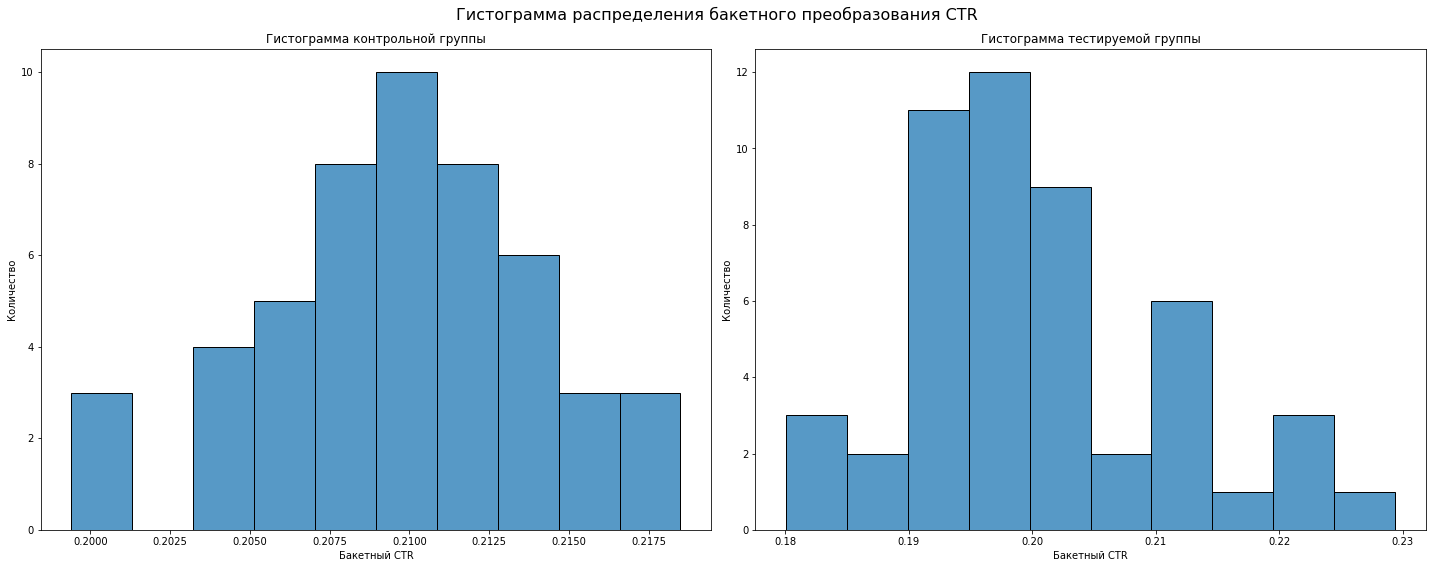

In [25]:
# построим два графика с бакетным CTR, для обеих групп
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Гистограмма распределения бакетного преобразования CTR', fontsize=16)

# построим первый график для контрольной группы
sns.histplot(backet[backet.exp_group == 1].bucket_ctr, ax=axs[0], bins=10, kde = False)
axs[0].set_title('Гистограмма контрольной группы')
axs[0].set_xlabel('Бакетный CTR')
axs[0].set_ylabel('Количество')

# построим график для тестируемой группы
sns.histplot(backet[backet.exp_group == 2].bucket_ctr,  ax=axs[1], bins=10, kde = False)
axs[1].set_title('Гистограмма тестируемой группы')
axs[1].set_xlabel('Бакетный CTR')
axs[1].set_ylabel('Количество')


plt.tight_layout() 
plt.show()

Распределения внутри бакеттов плюс/минус похоже на нормальное. Проведем t-тест

In [26]:
# t-тест 
results = stats.ttest_ind(backet[backet.exp_group == 1].bucket_ctr,
                backet[backet.exp_group == 2].bucket_ctr,
                equal_var=False)
alpha = 0.05

print('Среднее первой выборки', np.mean(backet[backet.exp_group == 1].bucket_ctr).round(5))
print('Среднее второй выборки', np.mean(backet[backet.exp_group == 2].bucket_ctr).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.20969
Среднее второй выборки 0.20046
t-статистика = 5.614819358149381
p-значение = 4.592644937473873e-07
Отвергаем нулевую гипотезу


**Вывод:** При проведении t-теста на бакетных CTR, тест увидел отличия. 

### Проведем тесты для 90%-го квантиля CTR

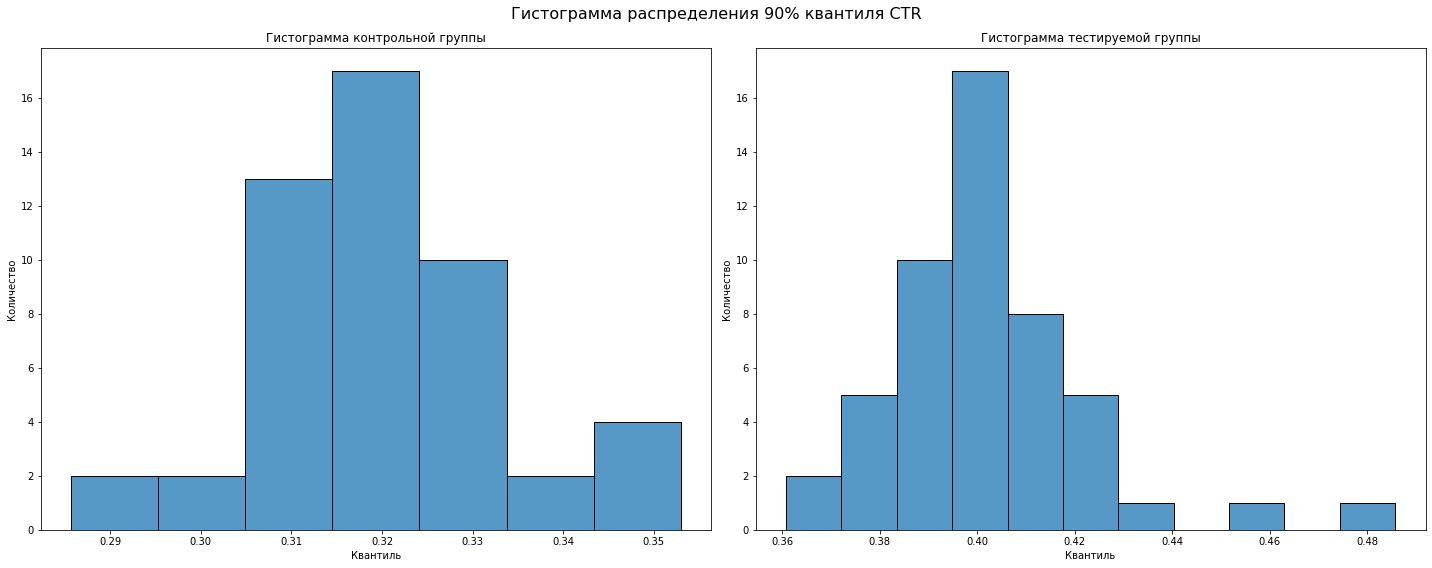

In [27]:
# построим два графика с обычным распределением и со сглаженным
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Гистограмма распределения 90% квантиля CTR', fontsize=16)

# построим первый график для контрольной группы
sns.histplot(backet[backet.exp_group == 1].ctr9, ax=axs[0], kde = False)
axs[0].set_title('Гистограмма контрольной группы')
axs[0].set_xlabel('Квантиль')
axs[0].set_ylabel('Количество')

# построим график для тестируемой группы
sns.histplot(backet[backet.exp_group == 2].ctr9,  ax=axs[1], kde = False)
axs[1].set_title('Гистограмма тестируемой группы')
axs[1].set_xlabel('Квантиль')
axs[1].set_ylabel('Количество')


plt.tight_layout() 
plt.show()

В связи с тем, что распределения данных можно с натяжкой привести к нормальному виду, а количество наблюдений ограничено, использование t-теста для анализа разницы в квантилях может быть неуместным. Вместо этого мы применили тест Манна-Уитни, который является непараметрическим методом и позволяет оценить различия между двумя независимыми группами без предположений о нормальности распределения.

In [28]:
#тест Манна-Уитни 
results = stats.mannwhitneyu(backet[backet.exp_group == 1].ctr9,
                backet[backet.exp_group == 2].ctr9,
                alternative = 'two-sided')
alpha = 0.05

print('Среднее первой выборки', np.mean(backet[backet.exp_group == 1].ctr9).round(5))
print('Среднее второй выборки', np.mean(backet[backet.exp_group == 2].ctr9).round(5))

print('t-статистика =', results.statistic)
print('p-значение =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее первой выборки 0.32099
Среднее второй выборки 0.40266
t-статистика = 0.0
p-значение = 6.7601631082665925e-18
Отвергаем нулевую гипотезу


**Вывод:** Результаты теста Манна-Уитни подтверждают наличие статистически значимых отличий между 90-м квантилем в группе 1 и группе 2. Это указывает на то, что распределение данных в этих группах различается, и, следовательно, изменения, внедренные в тестируемую группу, оказали влияние на результаты. 

## Общие выводы:
1. t-тест:

- Результаты t-теста не выявили статистически значимых различий между группами (p-value = 0.6853).
- Однако распределение CTR не удовлетворяет требованиям нормальности и имеет различные дисперсии между группами. Это снижает корректность применения t-теста в данном случае.

2. Тест Манна-Уитни:

- Тест Манна-Уитни показал наличие статистически значимых различий между группами (p-value = 4.63e-45). Это свидетельствует о том, что распределения CTR в тестовой и контрольной группах различаются.
- Этот тест является более подходящим для анализа, так как он не делает предположений о форме распределения данных, что важно для сильно асимметричных распределений, характерных для CTR.

3. Сглаживание CTR:

- После сглаживания распределение CTR стало ближе к нормальному. Это позволило повторно провести t-тест, однако статистически значимых отличий всё равно не было обнаружено.
- Несмотря на это, сглаживание помогло устранить влияние крайних значений, что делает такие данные более интерпретируемыми.

4. Пуассоновский бутстреп для подсчета разницы в CTR:

- Гистограммы показывают значительное различие в распределениях CTR между группами. Распределение контрольной группы (группа 1) выглядит более концентрированным, с пиком ближе к низким значениям CTR. В тестовой группе (группа 2) наблюдается длинный "хвост" высоких значений.
- При этом гистограмма разности между группами не пересекает ноль, что визуально подтверждает различия в CTR.
- Таким образом, результаты анализа показывают, что группа 1 (контрольная) демонстрирует лучшие результаты по CTR, чем группа 2 (тестируемая). Это может указывать на то, что изменения или нововведения, внедренные в тестируемую группу, не привели к улучшению показателей, а наоборот, снизили их эффективность. 

5. Анализ бакетных CTR и квантильный анализ CTR:

- T-тест на бакетных CTR показал статистически значимые различия между группами. Это подтверждает, что при учёте агрегированных данных (по бакетам) влияние случайных выбросов уменьшается, что позволяет выявить различия.
- Анализ 90-го квантиля с использованием теста Манна-Уитни подтвердил наличие значимых отличий. Это указывает на то, что изменения в тестовой группе влияют на верхние значения распределения CTR.

## Опишите потенциальную ситуацию, когда такое изменение могло произойти.

Анализ начального графика распределения показал, что уровень низкого CTR (около 0.1) в тестовой группе выше, чем в контрольной, что говорит о большом количестве пользователей с низкой вовлечённостью. Далее наблюдается снижение количества пользователей с CTR в диапазоне 0.1–0.2, затем рост в диапазоне 0.3–0.4 и последующее падение. Это может указывать на нестабильность работы нового алгоритма и его недостаточную релевантность для разных сегментов пользователей.

Потенциальная причина: Новый алгоритм рекомендаций может быть слишком фокусирован на популярном контенте или повторяющихся рекомендациях, что приводит к "утомлению" пользователей и снижению их интереса. В результате пользователи перестают взаимодействовать с рекомендациями. Возможно также наличие ошибки в логике работы алгоритма (например, некорректное ранжирование или ограниченный набор рекомендуемого контента).

## Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. 

На основании полученных результатов не рекомендуется раскатывать новый алгоритм на всех пользователей в его текущем виде. Наша цель заключалась в увеличении CTR, и результаты анализа показывают, что новый алгоритм не улучшает CTR, а снижает его. 

Новый алгоритм может утомлять пользователей повторяющимся или нерелевантным контентом. Это может привести к дальнейшему снижению вовлечённости, а в долгосрочной перспективе — к оттоку пользователей. Кроме того, важно учитывать, что негативный опыт пользователей может оказать влияние на общую репутацию платформы и снизить доверие к предоставляемым услугам.

**Рекомендация:**
Внедрить систему оценок: Позволить пользователям оценивать рекомендации по шкале (например, от 1 до 5) или с помощью простых кнопок "нравится/не нравится". Это даст возможность собрать количественные данные о том, какие рекомендации воспринимаются положительно, а какие — отрицательно.
